### K-Nearest Neighbours for Amazon fine food reviews for Bag of words, tf-idf, average word2vec, tf-idf weighted word2vec

### The objective

Given a text review, we have to predict whether the review represents positove sentiment or negative.
In other words, we ahve to classify the review as 'Positive' or 'Negative'.
We will use the Amazon fine food review dataset from Kaggle.com

First, import all required libraries


In [1]:
%%time
%matplotlib inline
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
import sqlite3
import pandas as pd
import numpy as np
import nltk
import pickle
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score
from nltk.stem.porter import PorterStemmer
import scipy
import warnings
warnings.filterwarnings('ignore')
import gensim
print('Done')

Done
Wall time: 58.5 s


In [2]:
from prettytable import PrettyTable
#source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,6), fontsize=10):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
def print_classif_report(input_dict):
    tab = PrettyTable()
    tab.field_names = ["Label","Precision","Recall","f1-Score","Support"]
    list1=[]
    for k,v in input_dict.items():
        list1=[]
        list1.append(k)
        for i,j in v.items():
            list1.append("{0:.2f}".format(j))
        
        tab.add_row(list1)
    print(tab)    

In [3]:
#store the avg word2vec to disk as file for reuse later
import pickle
def load_from_file(file_name):
    
    with open(file_name, 'rb') as filehandle:  
        # read the data as binary data stream
        list1 = pickle.load(filehandle)
        return list1
    
def dump_to_file(data,file_name):
    with open(file_name, 'wb') as filehandle:  
        # store the data as binary data stream
        pickle.dump(data, filehandle)


Read the data from database.
We will not consider 3 star reviews as they are neutral (neither completely positive nor negative)

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 as they are neutral

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

#Function to map reviews with Score>3 to a positive rating, and reviews with a score<3 to a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition)

Check the sample data

In [3]:
filtered_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [4]:
filtered_data['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

The data is heavily imbalanced with the number of positive reviews far surpassing the number of negative reviews.

Now, let us Sort the data by productid

In [5]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

If multiple reviews are present by same user and profilename at the same time and with same text, remove duplicates 

In [6]:
#Remove duplicate reviews by same user at same time
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Remove rows where helpfulness denominator is greater than helpfulness numerator

In [7]:
#Keep only those records where HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

Function to clean the sentences.
The function will remove html tags and punctuation marks from the input text and return cleaned text.

In [4]:
import re
import string
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
print(stop)
def cleansentence(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r'[?|!|\'|"|#]',r'',cleantext)
    cleantext = re.sub(r'[.|,|)|(|\|/|-|+|;|&]',r' ',cleantext)
    return  cleantext


{"aren't", 'weren', 'now', 'o', 'd', 'nor', 'too', 'y', 'do', "wouldn't", 'wouldn', 'she', 'was', 'through', 's', 'mightn', 'it', 'what', 'are', 'any', "isn't", 'such', 'yourselves', "should've", 'while', 'am', 'doing', 'between', 'be', 'the', "don't", 'should', 'couldn', 'where', "you've", 'does', 'hadn', 'being', 'ourselves', 'most', "you'll", "shouldn't", "she's", 'which', 'that', 'when', "won't", "you're", 'whom', 'but', "couldn't", 'm', 'as', 'than', 'yours', 'these', 'because', 'he', 've', "it's", 'of', "wasn't", "shan't", "doesn't", "mustn't", 'wasn', 'at', 'my', 'hers', 'here', 'mustn', 'his', 'our', 'is', 'then', 'in', 'very', 'ain', 'needn', 'shan', 'for', 're', "mightn't", 'each', 'more', 'why', 'to', 'its', 'they', 'has', 'off', "you'd", 'how', 'from', "that'll", 'there', 'once', 'a', 'this', 'until', 'both', 'further', 'down', 'over', 'not', 'himself', 'won', 'ma', 'shouldn', 'all', "needn't", 'about', 'her', 'who', 'didn', 'we', 'their', "didn't", 'below', 'will', 'theirs

Sort by time for time based splitting

In [9]:
sample=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sample=sample[:64000]

Cleaning the review text by using above written function.
Also performing the stemming procedure to reduce the words to their base stem forms.
Cleaned text will be stored in separate column.
For tf-idf weighted word2vec, we are storing non-stemmed clean review text in another column.

In [10]:
i=0
str1=' '
str2=' '
final_string=[]
final_string_2=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
s1=''
for sent in sample['Text'].values:
    filtered_sentence=[]
    filtered_nostem = []
    #print(sent);
    sent=cleansentence(sent) # remove HTMl tags
    for w in sent.split():
        if((w.isalpha()) & (len(w)>2)):    
                if(w.lower() not in stop):
                    s=(sno.stem(w.lower())).encode('utf8')
                    s1 = (w.lower()).encode('utf8')
                    filtered_sentence.append(s)
                    filtered_nostem.append(s1)
                    
                else:
                    continue
        else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    str2 = b" ".join(filtered_nostem) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    final_string_2.append(str2)
    i+=1

In [11]:
#adding a column named CleanedText which displays the data after pre-processing of the review 
sample['CleanedText']=final_string
sample['CleanedTextNoStem']=final_string_2

In [12]:
import pickle

Save the cleaned text in a file for use later

In [13]:
#pickle.dump(sample,open('cleaned_final.p','wb'))
pd.to_pickle(sample,'cleaned_final.pkl')

In [5]:
testdf=pd.read_pickle('cleaned_final.pkl')

In [6]:
sample=testdf
#filtered_data=testdf

In [7]:
#sample.head(1)
sample.head(1)
#sample['Score'].value_counts()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedTextNoStem
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...


### First using Bag of Words vectorizer

In [8]:
#sort by time for time based splitting
sample=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
from sklearn.model_selection import train_test_split

x_train1, x_test, y_train1, y_test = train_test_split(sample['CleanedText'].values,sample['Score'].values,test_size=0.2,shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train1,y_train1,test_size=0.2,shuffle=False)

In [25]:
count_vect = CountVectorizer(ngram_range=(1,2),max_features=2000,min_df=50)
bag_of_words_train = count_vect.fit_transform(x_train)
bag_of_words_val =  count_vect.transform(x_val)
bag_of_words_test =  count_vect.transform(x_test)

print(bag_of_words_train.shape)
print(bag_of_words_val.shape)
print(bag_of_words_test.shape)


(40960, 2000)
(10240, 2000)
(12800, 2000)


Save the results into disk for reuse.

In [26]:
import scipy.sparse
scipy.sparse.save_npz('bag_of_words_train', bag_of_words_train)
scipy.sparse.save_npz('bag_of_words_val', bag_of_words_val)
scipy.sparse.save_npz('bag_of_words_test', bag_of_words_test)
bag_of_words_val=scipy.sparse.load_npz('bag_of_words_val.npz')
bag_of_words_test=scipy.sparse.load_npz('bag_of_words_test.npz')
bag_of_words_train=scipy.sparse.load_npz('bag_of_words_train.npz')

### K-NN for bag of words

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


neighbors = range(1,50,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='brute',n_jobs = 1) #first try brute algorithm
    knn.fit(bag_of_words_train,y_train)
    pred = knn.predict(bag_of_words_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))
    
   


starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9
starting for k= 11
starting for k= 13
starting for k= 15
starting for k= 17
starting for k= 19
starting for k= 21
starting for k= 23
starting for k= 25
starting for k= 27
starting for k= 29
starting for k= 31
starting for k= 33
starting for k= 35
starting for k= 37
starting for k= 39
starting for k= 41
starting for k= 43
starting for k= 45
starting for k= 47
starting for k= 49


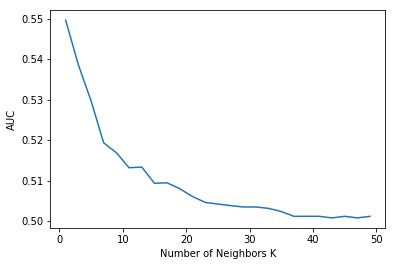

optimal k is  1


In [28]:
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show() 

print('optimal k is ', neighbors[scores.index(max(scores))])


In [33]:
scores.index(max(scores))

0

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.26   |  0.21  |   0.23   | 1666.00  |
|      1       |    0.88   |  0.91  |   0.90   | 11134.00 |
|  micro avg   |    0.82   |  0.82  |   0.82   | 12800.00 |
|  macro avg   |    0.57   |  0.56  |   0.56   | 12800.00 |
| weighted avg |    0.80   |  0.82  |   0.81   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


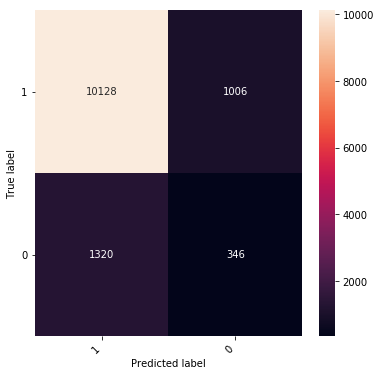

In [29]:
#test evaluation

knn = KNeighborsClassifier(n_neighbors=1,algorithm = 'brute')
knn.fit(bag_of_words_train,y_train)
pred = knn.predict(bag_of_words_test)
bow_score = roc_auc_score(y_test,pred)
print('Classification report for k = 1 :-')
bow_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(bow_dict)
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

# Using TF-IDF Vectorizer

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy import sparse

tfidf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=50,max_features=2000)
tfidf_train = tfidf_vect.fit_transform(x_train)

tfidf_val =  tfidf_vect.transform(x_val) #use same vectorizer to transform test instances
tfidf_test =  tfidf_vect.transform(x_test) #use same vectorizer to transform test instances

#Store to disk for later reuse

scipy.sparse.save_npz('tfidf_test', tfidf_test)
scipy.sparse.save_npz('tfidf_train', tfidf_train)
scipy.sparse.save_npz('tfidf_val', tfidf_val)

starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9
starting for k= 11
starting for k= 13
starting for k= 15
starting for k= 17
starting for k= 19
starting for k= 21
starting for k= 23
starting for k= 25
starting for k= 27
starting for k= 29
starting for k= 31
starting for k= 33
starting for k= 35
starting for k= 37
starting for k= 39
starting for k= 41
starting for k= 43
starting for k= 45
starting for k= 47
starting for k= 49


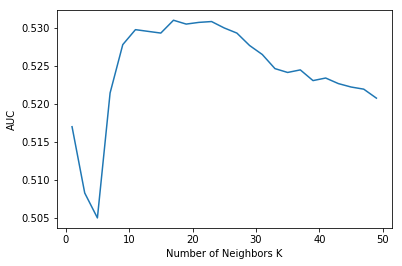

optimal k is  17


In [31]:
neighbors = range(1,50,2)

AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='brute',n_jobs = 1) #first try brute algorithm
    knn.fit(tfidf_train,y_train)
    pred = knn.predict(tfidf_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 17 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.82   |  0.04  |   0.08   | 1666.00  |
|      1       |    0.87   |  1.00  |   0.93   | 11134.00 |
|  micro avg   |    0.87   |  0.87  |   0.87   | 12800.00 |
|  macro avg   |    0.85   |  0.52  |   0.51   | 12800.00 |
| weighted avg |    0.87   |  0.87  |   0.82   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 17 :-


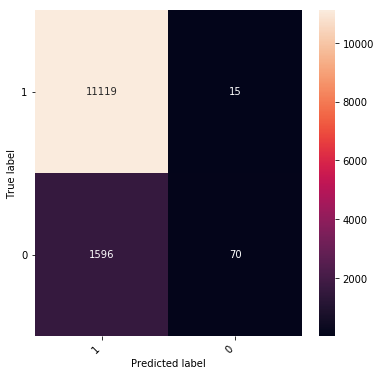

In [32]:
#Test metrics for optimal K = 17

knn = KNeighborsClassifier(n_neighbors=17,algorithm = 'brute')
knn.fit(tfidf_train,y_train)
pred = knn.predict(tfidf_test)
tfidf_score = roc_auc_score(y_test,pred)
print('Classification report for k = 17 :-')
tfidf_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(tfidf_dict )
print('Confusion matrix for k = 17 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

## K-NN for average word2Vec

In [41]:
from nltk.tokenize import word_tokenize

train_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[:40960]]]
val_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[40960:51200]]]
test_list = [ [w.lower() for w in word_tokenize(clean_rev) if ((w not in stop) & (w.isalpha()) & (len(w)>2))] for clean_rev in [cleansentence(review) for review in sample['Text'].values[51200:]]]


In [43]:
dump_to_file(train_list,'train_list.data')
dump_to_file(val_list,'val_list.data')
dump_to_file(test_list,'test_list.data')
train_list = load_from_file('train_list.data')
val_list = load_from_file('val_list.data')
test_list = load_from_file('test_list.data')

In [44]:
print(len(train_list))
print(len(val_list))
print(len(test_list))

40960
10240
12800


In [46]:
w2v_model = gensim.models.Word2Vec(train_list,min_count=50,size=300)

We can use the model to lookup similar words in the vocabulary for any given word.

In [47]:
print(w2v_model.most_similar('good'))
print('******************************************************************************')
print(w2v_model.most_similar('bad'))

[('great', 0.7057865858078003), ('decent', 0.6415238380432129), ('amazing', 0.6297118663787842), ('terrific', 0.6242681741714478), ('awesome', 0.6162838339805603), ('fantastic', 0.5743992328643799), ('bad', 0.5608528852462769), ('gross', 0.5514618158340454), ('excellent', 0.548914909362793), ('horrible', 0.5455313324928284)]
******************************************************************************
[('gross', 0.7655400037765503), ('horrible', 0.7439913749694824), ('terrible', 0.7396768927574158), ('nasty', 0.7170189619064331), ('awful', 0.7062533497810364), ('weird', 0.7051079273223877), ('okay', 0.7046031951904297), ('funny', 0.6879370808601379), ('mean', 0.6780930757522583), ('strange', 0.6461969614028931)]


In [48]:
avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in train_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if(cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    avg_wt_vecs.append(sent_vec) #append to list of sentence vectors 

In [49]:
print(np.isfinite(avg_wt_vecs).all())
print(np.isnan(avg_wt_vecs).any())

True
False


In [50]:
val_avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list

for sentence in val_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    
    if (cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    val_avg_wt_vecs.append(sent_vec) #append to list of sentence vectors
    


In [51]:
print(np.isfinite(val_avg_wt_vecs).all())
print(np.isnan(val_avg_wt_vecs).any())

True
False


In [52]:
test_avg_wt_vecs = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in test_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec  #add each component of sentence vector with each component of word vector
            cnt_words += 1   #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if(cnt_words!=0):
        sent_vec /= cnt_words #each component of sentence vector has been divided by the count of words in the sentence 
    test_avg_wt_vecs.append(sent_vec) #append to list of sentence vectors

In [53]:
print(np.isfinite(test_avg_wt_vecs).all())
print(np.isnan(test_avg_wt_vecs).any())

True
False


In [54]:
X_tr = avg_wt_vecs
X_test = test_avg_wt_vecs
X_val = val_avg_wt_vecs
print(len(val_avg_wt_vecs))
print(len(test_avg_wt_vecs))
print(len(avg_wt_vecs))

10240
12800
40960


starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9
starting for k= 11
starting for k= 13
starting for k= 15
starting for k= 17
starting for k= 19
starting for k= 21
starting for k= 23
starting for k= 25
starting for k= 27
starting for k= 29
starting for k= 31
starting for k= 33
starting for k= 35
starting for k= 37
starting for k= 39
starting for k= 41
starting for k= 43
starting for k= 45
starting for k= 47
starting for k= 49
starting for k= 51
starting for k= 53
starting for k= 55
starting for k= 57
starting for k= 59
starting for k= 61
starting for k= 63
starting for k= 65
starting for k= 67
starting for k= 69
starting for k= 71
starting for k= 73
starting for k= 75
starting for k= 77
starting for k= 79
starting for k= 81
starting for k= 83
starting for k= 85
starting for k= 87
starting for k= 89
starting for k= 91
starting for k= 93
starting for k= 95
starting for k= 97
starting for k= 99


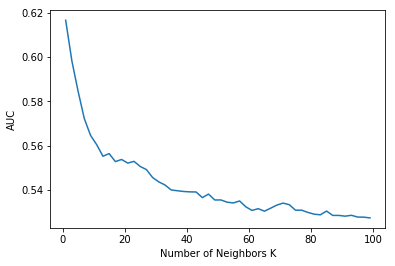

optimal k is  1


In [55]:
neighbors = range(1,100,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='brute',n_jobs = 1) #first try brute algorithm
    knn.fit(X_tr,y_train)
    pred = knn.predict(X_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.38   |  0.28  |   0.32   | 1666.00  |
|      1       |    0.90   |  0.93  |   0.91   | 11134.00 |
|  micro avg   |    0.85   |  0.85  |   0.85   | 12800.00 |
|  macro avg   |    0.64   |  0.61  |   0.62   | 12800.00 |
| weighted avg |    0.83   |  0.85  |   0.84   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


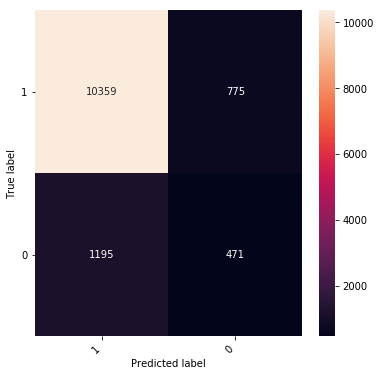

In [57]:
#Test metrics for optimal K = 10
knn = KNeighborsClassifier(n_neighbors=1,algorithm = 'brute')
knn.fit(X_tr,y_train)
pred = knn.predict(X_test)
avg_w2v_score = roc_auc_score(y_test,pred)
print('Classification report for k = 1 :-')
avg_w2v_dict = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(avg_w2v_dict )
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

Let us store the data to disk for reuse.

In [11]:
dump_to_file(avg_wt_vecs,'avg_wt_vecs_train.data')
dump_to_file(val_avg_wt_vecs,'val_avg_wt_vecs.data')
dump_to_file(test_avg_wt_vecs,'test_avg_wt_vecs.data')
avg_wt_vecs=load_from_file('avg_wt_vecs_train.data')
val_avg_wt_vecs=load_from_file('val_avg_wt_vecs.data')
test_avg_wt_vecs=load_from_file('test_avg_wt_vecs.data')

## K-NN for tf-idf weighted word2vec

In [12]:
X_tr1, X_test, y_tr1, y_test = train_test_split(sample['CleanedTextNoStem'].values, sample['Score'].values, test_size=0.2,shuffle=False)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr1, y_tr1, test_size=0.2,shuffle=False)

In [60]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=2000,min_df=50)
tfidf_train = tfidf_vect.fit_transform(X_tr)

tfidf_test =  tfidf_vect.transform(X_test) #use same vectorizer to transform test instances
tfidf_val =  tfidf_vect.transform(X_val) #use same vectorizer to transform test instances

features = tfidf_vect.get_feature_names()
#len(features)
dict_feature={}
idx=0
for feature in features:
    dict_feature[feature]=idx
    idx += 1
#len(features)

In [61]:
index = 0
tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in train_list: # for each review/sentence
    
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    
    if sum_tfidf != 0:
            sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    
       
    tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    
    index += 1
    

In [62]:
print(np.isfinite(tfidf_wt_vecs).all())
print(np.isnan(tfidf_wt_vecs).any())

True
False


In [63]:
index = 0
val_tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in val_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_val[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if sum_tfidf !=0:
        sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    val_tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    #if print(index,sent_vec,sum_tfidf)
    index += 1
    

In [64]:
print(np.isfinite(val_tfidf_wt_vecs).all())
print(np.isnan(val_tfidf_wt_vecs).any())

True
False


In [65]:
index = 0
test_tfidf_wt_vecs = []; # the tfidf-w2v for each sentence/review in train set is stored in this list
for sentence in test_list: # for each review/sentence
    sent_vec = np.zeros(300) #initialize the vector for the sentence with all 50 components 0
    sum_tfidf = 0;
    for word in sentence: # for each word in a sentence; here sentence is a list of words
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[index,dict_feature.get(word)]
            sent_vec += tfidf*vec  #add each component of sentence vector with each component of word vector
            sum_tfidf +=  tfidf  #count of words with vector in word2vec model incremented by 1 
        except:
            pass #word not present in word2vec model vocabulary
    if sum_tfidf !=0:
        sent_vec /= sum_tfidf #each component of sentence vector has been divided by the count of words in the sentence 
    test_tfidf_wt_vecs.append(sent_vec) #append to list of sentence vectors
    #if print(index,sent_vec,sum_tfidf)
    index += 1
    

In [66]:
print(np.isfinite(test_tfidf_wt_vecs).all())
print(np.isnan(test_tfidf_wt_vecs).any())

True
False


In [67]:
X_tr = tfidf_wt_vecs
X_test = test_tfidf_wt_vecs
X_val = val_tfidf_wt_vecs

Store to disk for later use

In [68]:
dump_to_file(test_tfidf_wt_vecs,'test_tfidf_wt_vecs.data')
dump_to_file(tfidf_wt_vecs,'tfidf_wt_vecs.data')
dump_to_file(val_tfidf_wt_vecs,'val_tfidf_wt_vecs.data')
#tfidf_wt_vecs = load_from_file('tfidf_wt_vecs.data')
#val_tfidf_wt_vecs = load_from_file('val_tfidf_wt_vecs.data')
#test_tfidf_wt_vecs = load_from_file('test_tfidf_wt_vecs.data')

starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9
starting for k= 11
starting for k= 13
starting for k= 15
starting for k= 17
starting for k= 19
starting for k= 21
starting for k= 23
starting for k= 25
starting for k= 27
starting for k= 29
starting for k= 31
starting for k= 33
starting for k= 35
starting for k= 37
starting for k= 39
starting for k= 41
starting for k= 43
starting for k= 45
starting for k= 47
starting for k= 49
starting for k= 51
starting for k= 53
starting for k= 55
starting for k= 57
starting for k= 59
starting for k= 61
starting for k= 63
starting for k= 65
starting for k= 67
starting for k= 69
starting for k= 71
starting for k= 73
starting for k= 75
starting for k= 77
starting for k= 79
starting for k= 81
starting for k= 83
starting for k= 85
starting for k= 87
starting for k= 89
starting for k= 91
starting for k= 93
starting for k= 95
starting for k= 97
starting for k= 99


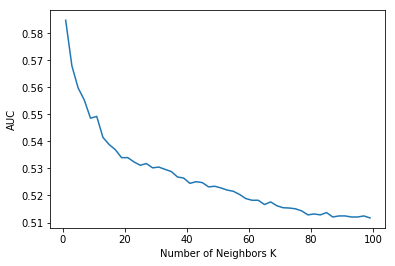

optimal k is  1


In [69]:
neighbors = range(1,100,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='brute',n_jobs = 1) #first try brute algorithm
    knn.fit(X_tr,y_train)
    pred = knn.predict(X_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.35   |  0.28  |   0.31   | 1666.00  |
|      1       |    0.90   |  0.92  |   0.91   | 11134.00 |
|  micro avg   |    0.84   |  0.84  |   0.84   | 12800.00 |
|  macro avg   |    0.62   |  0.60  |   0.61   | 12800.00 |
| weighted avg |    0.82   |  0.84  |   0.83   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


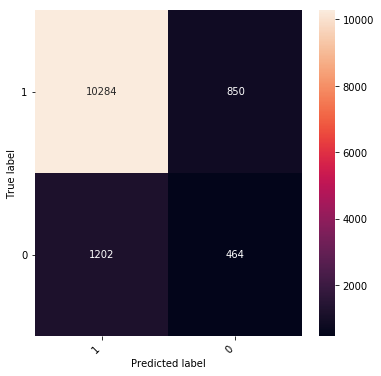

In [71]:
#Test metrics for optimal K = 10

knn = KNeighborsClassifier(n_neighbors=1,algorithm = 'brute')
knn.fit(X_tr,y_train)
pred = knn.predict(X_test)
score = roc_auc_score(y_test,pred)
print('Classification report for k = 1 :-')
dict1 = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(dict1 )
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])

## Conclusion for brute force KNN:-

The Test statistics for each vectorization is summarized in the below table.

In [33]:
tab = PrettyTable()
tab.field_names = ["Model","Optimal Hyper-parameter K","Positive Precision","Positive Recall","Negative precision","Negative Recall"]
list1=["BOW bigram","1","0.88","0.91","0.26","0.21"]
list2=["TFIDF bigram","17","0.84","1.00","0.91","0.08"]
list3=["Avg w2v","1","0.90","0.93","0.38","0.28"]
list4=["TFIDF w2v","1","0.90","0.92","0.35","0.28"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
print(tab) 

+--------------+---------------------------+--------------------+-----------------+--------------------+-----------------+
|    Model     | Optimal Hyper-parameter K | Positive Precision | Positive Recall | Negative precision | Negative Recall |
+--------------+---------------------------+--------------------+-----------------+--------------------+-----------------+
|  BOW bigram  |             1             |        0.88        |       0.91      |        0.26        |       0.21      |
| TFIDF bigram |             17            |        0.84        |       1.00      |        0.91        |       0.08      |
|   Avg w2v    |             1             |        0.90        |       0.93      |        0.38        |       0.28      |
|  TFIDF w2v   |             1             |        0.90        |       0.92      |        0.35        |       0.28      |
+--------------+---------------------------+--------------------+-----------------+--------------------+-----------------+


All the vectorization have reasonable precision and recall scores for the positive class.
However, the precision and recall for the negative class is not good for any vectorization.
K-NN is a very naive and simple algorithm and for such an imbalanced dataset, it does not perform well for the minority class.

### KD_TREE KNN

KD_TREE algorithm is efficient for nearest neighbour search in lower dimensions.

However, it loses its efficiency in high dimensions if the number of data points are not enough.
As a thumb rule, if N is the number of data points and the dimensionality is D, kd_tree should be applied only if N >> 2^D.

So, to try kd_tree approach vectorizers on the Test set we have to use truncatedSVD for dimensionality reduction beforehand.

### KD_tree KNN For Avg word2vec

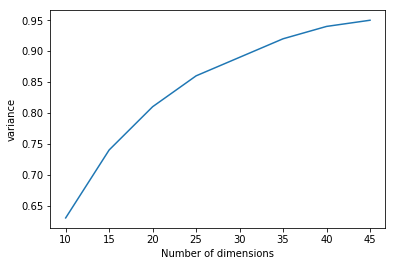

maximum variance for dimension 45


In [47]:

X_tr = avg_wt_vecs
X_test = test_avg_wt_vecs
X_val = val_avg_wt_vecs

dims = range(10,50,5)

var=[]

for dim in dims:
    
    svd=TruncatedSVD(n_components = dim)
    svd.fit(X_tr)
    var.append(round(svd.explained_variance_ratio_.sum(),2))
    
plt.plot(dims, var)
plt.xlabel('Number of dimensions')
plt.ylabel('variance')
plt.show()        

print('maximum variance for dimension',dims[var.index(max(var))])
svd = TruncatedSVD(n_components = dims[var.index(max(var))])
X_tr=svd.fit_transform(X_tr)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_test=svd.transform(X_test)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_val=svd.transform(X_val)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())

starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9


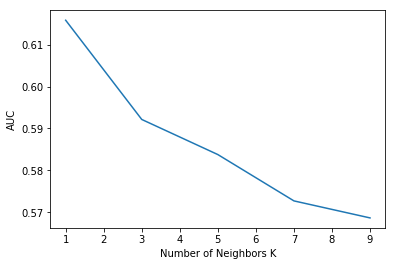

optimal k is  1
Wall time: 1min 29s


In [50]:
%%time

neighbors = range(1,10,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='kd_tree',n_jobs = -1) #first try brute algorithm
    knn.fit(X_tr,y_train)
    pred = knn.predict(X_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.38   |  0.30  |   0.34   | 1666.00  |
|      1       |    0.90   |  0.93  |   0.91   | 11134.00 |
|  micro avg   |    0.85   |  0.85  |   0.85   | 12800.00 |
|  macro avg   |    0.64   |  0.61  |   0.63   | 12800.00 |
| weighted avg |    0.83   |  0.85  |   0.84   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


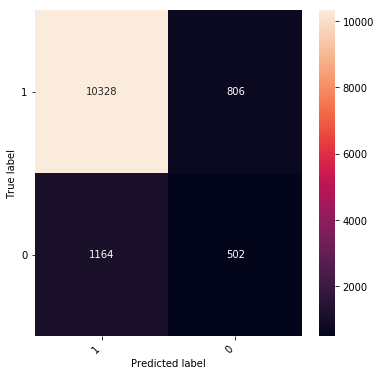

In [51]:
#test evaluation
knn = KNeighborsClassifier(n_neighbors = 1, algorithm='kd_tree',n_jobs = -1)
knn.fit(X_tr,y_train)
pred = knn.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print('Classification report for k = 1 :-')
dict1 = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(dict1 )
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])


### KD tree KNN for tf-idf weighted word2vec

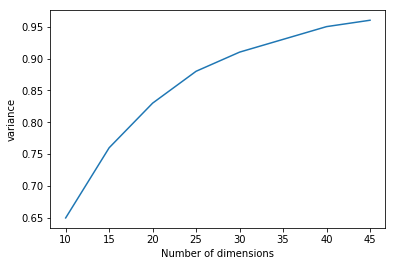

maximum variance for dimension 45
Wall time: 12.9 s


In [52]:
%%time
#Test metrics for optimal K = 10

tfidf_wt_vecs=load_from_file('tfidf_wt_vecs.data')
test_tfidf_wt_vecs=load_from_file('test_tfidf_wt_vecs.data')
val_tfidf_wt_vecs=load_from_file('val_tfidf_wt_vecs.data')

X_tr = tfidf_wt_vecs
X_test = test_tfidf_wt_vecs
X_val=val_tfidf_wt_vecs


dims = range(10,50,5)

var=[]

for dim in dims:
    
    svd=TruncatedSVD(n_components = dim)
    svd.fit(X_tr)
    var.append(round(svd.explained_variance_ratio_.sum(),2))
    
plt.plot(dims, var)
plt.xlabel('Number of dimensions')
plt.ylabel('variance')
plt.show()        

print('maximum variance for dimension',dims[var.index(max(var))])
svd = TruncatedSVD(n_components = dims[var.index(max(var))])
X_tr=svd.fit_transform(X_tr)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_test=svd.transform(X_test)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_val=svd.transform(X_val)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())

starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9


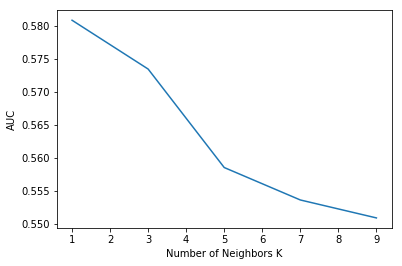

optimal k is  1
Wall time: 1min 14s


In [53]:
%%time

neighbors = range(1,10,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='kd_tree',n_jobs = -1) #first try brute algorithm
    knn.fit(X_tr,y_train)
    pred = knn.predict(X_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.35   |  0.28  |   0.31   | 1666.00  |
|      1       |    0.90   |  0.92  |   0.91   | 11134.00 |
|  micro avg   |    0.84   |  0.84  |   0.84   | 12800.00 |
|  macro avg   |    0.63   |  0.60  |   0.61   | 12800.00 |
| weighted avg |    0.83   |  0.84  |   0.83   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


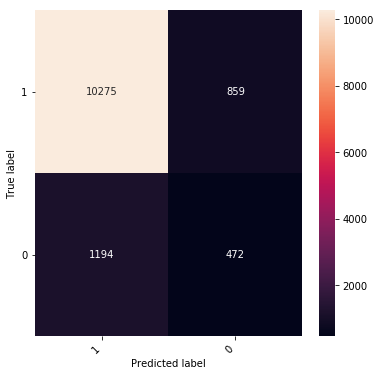

In [54]:
#test valuation
knn = KNeighborsClassifier(n_neighbors = 1, algorithm='kd_tree',n_jobs=-1)
knn.fit(X_tr,y_train)
pred = knn.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print('Classification report for k = 1 :-')
dict1 = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(dict1 )
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])


### KD tree KNN for BOW

In [64]:
%%time

from scipy import sparse

bag_of_words_val=scipy.sparse.load_npz('bag_of_words_val.npz')
bag_of_words_test=scipy.sparse.load_npz('bag_of_words_test.npz')
bag_of_words_train=scipy.sparse.load_npz('bag_of_words_train.npz')

X_tr = bag_of_words_train
X_test = bag_of_words_test
X_val= bag_of_words_val


dims = range(100,1000,100)

var=[]

for dim in dims:
    print('starting dim = ',dim)
    svd=TruncatedSVD(n_components = dim)
    svd.fit(X_tr)
    var.append(round(svd.explained_variance_ratio_.sum(),2))
    
plt.plot(dims, var)
plt.xlabel('Number of dimensions')
plt.ylabel('variance')
plt.show()        

#print('maximum variance for dimension',dims[var.index(max(var))])



Wall time: 125 ms


In [65]:
svd = TruncatedSVD(n_components = 1000)
X_tr=svd.fit_transform(X_tr)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_test=svd.transform(X_test)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_val=svd.transform(X_val)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())

starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9


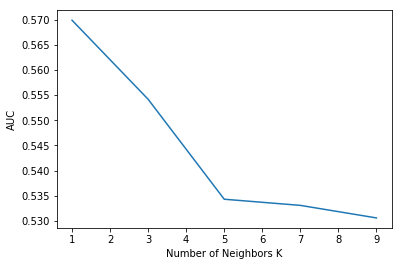

optimal k is  1
Wall time: 32min 8s


In [66]:
%%time

neighbors = range(1,10,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='kd_tree',n_jobs = -1) #first try brute algorithm
    knn.fit(X_tr,y_train)
    pred = knn.predict(X_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.27   |  0.27  |   0.27   | 1666.00  |
|      1       |    0.89   |  0.89  |   0.89   | 11134.00 |
|  micro avg   |    0.81   |  0.81  |   0.81   | 12800.00 |
|  macro avg   |    0.58   |  0.58  |   0.58   | 12800.00 |
| weighted avg |    0.81   |  0.81  |   0.81   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


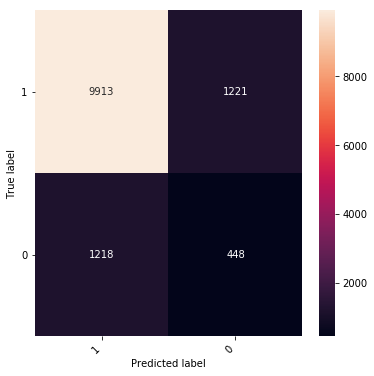

In [67]:
knn = KNeighborsClassifier(n_neighbors = 1, algorithm='kd_tree',n_jobs = -1)
knn.fit(X_tr,y_train)
pred = knn.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print('Classification report for k = 1 :-')
dict1 = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(dict1 )
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])


### KD tree KNN for TF-IDF

In [71]:
tfidf_test=scipy.sparse.load_npz('tfidf_test.npz')
tfidf_train=scipy.sparse.load_npz('tfidf_train.npz')
tfidf_val=scipy.sparse.load_npz('tfidf_val.npz')

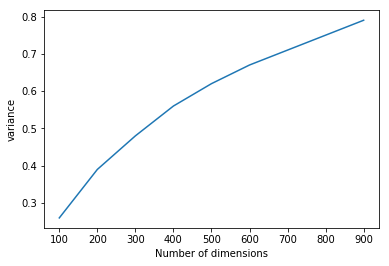

maximum variance for dimension 900
Wall time: 3min 25s


In [72]:
%%time

X_tr = tfidf_train
X_test = tfidf_test
X_val= tfidf_val

dims = range(100,1000,100)

var=[]

for dim in dims:
    
    svd=TruncatedSVD(n_components = dim)
    svd.fit(X_tr)
    var.append(round(svd.explained_variance_ratio_.sum(),2))
    
plt.plot(dims, var)
plt.xlabel('Number of dimensions')
plt.ylabel('variance')
plt.show()        

print('maximum variance for dimension',dims[var.index(max(var))])
svd = TruncatedSVD(n_components = dims[var.index(max(var))])
X_tr=svd.fit_transform(X_tr)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_test=svd.transform(X_test)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())
X_val=svd.transform(X_val)
#print("Cumulative explained variance ration for train:",svd.explained_variance_ratio_.sum())

starting for k= 1
starting for k= 3
starting for k= 5
starting for k= 7
starting for k= 9


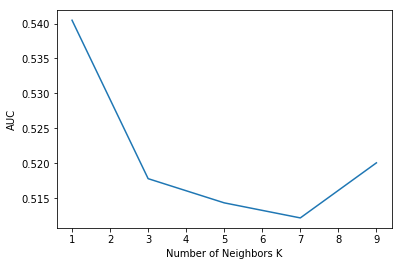

optimal k is  1
Wall time: 26min 55s


In [73]:
%%time

neighbors = range(1,10,2)

#AUC=dict()
scores=[]

for num_neighbour in  neighbors:
    print('starting for k=',num_neighbour)
    knn = KNeighborsClassifier(n_neighbors = num_neighbour, algorithm='kd_tree',n_jobs = -1) #first try brute algorithm
    knn.fit(X_tr,y_train)
    pred = knn.predict(X_val)
    #AUC[num_neighbour]=roc_auc_score(y_val,pred)
    scores.append(roc_auc_score(y_val,pred))   
    
plt.plot(neighbors, scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('AUC')
plt.show()

print('optimal k is ', neighbors[scores.index(max(scores))])

Classification report for k = 1 :-
+--------------+-----------+--------+----------+----------+
|    Label     | Precision | Recall | f1-Score | Support  |
+--------------+-----------+--------+----------+----------+
|      0       |    0.27   |  0.16  |   0.20   | 1666.00  |
|      1       |    0.88   |  0.94  |   0.91   | 11134.00 |
|  micro avg   |    0.83   |  0.83  |   0.83   | 12800.00 |
|  macro avg   |    0.58   |  0.55  |   0.55   | 12800.00 |
| weighted avg |    0.80   |  0.83  |   0.82   | 12800.00 |
+--------------+-----------+--------+----------+----------+
Confusion matrix for k = 1 :-


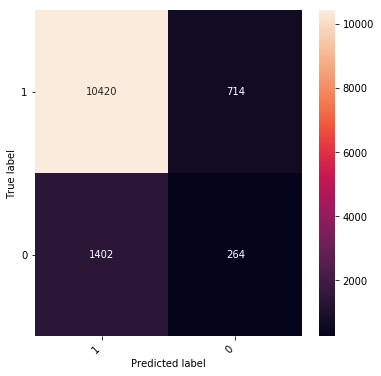

In [74]:
knn = KNeighborsClassifier(n_neighbors = 1, algorithm='kd_tree',n_jobs = -1)
knn.fit(X_tr,y_train)
pred = knn.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print('Classification report for k = 1 :-')
dict1 = metrics.classification_report(y_test,pred,output_dict=True)
print_classif_report(dict1 )
print('Confusion matrix for k = 1 :-')
print_confusion_matrix(confusion_matrix(y_test, pred,labels=[1,0]), [1,0])


### Summary for KD tree KNN

In [76]:
tab = PrettyTable()
tab.field_names = ["Model","Optimal Hyper-parameter K","Positive Precision","Positive Recall","Negative precision","Negative Recall"]
list1=["BOW bigram","1","0.89","0.89","0.27","0.27"]
list2=["TFIDF bigram","1","0.88","0.94","0.27","0.16"]
list3=["Avg w2v","1","0.90","0.93","0.38","0.30"]
list4=["TFIDF w2v","1","0.90","0.92","0.35","0.28"]
tab.add_row(list1)
tab.add_row(list2)
tab.add_row(list3)
tab.add_row(list4)
print(tab) 

+--------------+---------------------------+--------------------+-----------------+--------------------+-----------------+
|    Model     | Optimal Hyper-parameter K | Positive Precision | Positive Recall | Negative precision | Negative Recall |
+--------------+---------------------------+--------------------+-----------------+--------------------+-----------------+
|  BOW bigram  |             1             |        0.89        |       0.89      |        0.27        |       0.27      |
| TFIDF bigram |             1             |        0.88        |       0.94      |        0.27        |       0.16      |
|   Avg w2v    |             1             |        0.90        |       0.93      |        0.38        |       0.30      |
|  TFIDF w2v   |             1             |        0.90        |       0.92      |        0.35        |       0.28      |
+--------------+---------------------------+--------------------+-----------------+--------------------+-----------------+
